# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Business Questions 

Target marketing is getting more and more popular nowadays due to its advantages compared to some traditional ways of marketing. By breaking the market into different segments, target marketing saves companies unnecessary effort and enables them to focus on the key segments consisting of customers who match the products and services the best. 

In order to be able to focus on key groups of the customers and adjust our marketing strategies according to different groups, we need to first identify the features of these different customer groups. Based on that, we can apply different marketing/advertizing strategies in a more group-based manner and thus achieve the best profit/marketing cost scenario.

In this project, I will use the Starbucks's data to indentify different user groups and answer these two questions:

1. Which groups of people are most responsive to each type of the three offers, including discount, buy one get one for free (bogo), and informational.


2. How can we best present each type of offer i.e. email, mobile, web, or social, to the users? 

# Data Understanding

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Data Preparation

With the business questions in mind and the data files at hand, I would apply the principles of the ETL process to extract, transform, and load the data. In this case, I will export the cleaned dataset as a csv file to the local disk for future use. 

In this part, I will first take an overall look at the data and try to build up some intuition about how I can use the data to answer my questions. Then I will start doing some necessary data wragling to prepare the data for further analysis.

### ETL process step 1: extract

Load the original datasets and take a quick look at how the data looks like.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [20]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [21]:
# Take a look at the shapes of the datasets
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

In [22]:
# Take a look at the data file one by one
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [23]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### ETL process step 2: transform

In this part, I will do necessary data wrangling to clean, transform and reshape the data in order to make it ready for the future use. The procesures that I would go through include:

1. Transforming the 'became_member_on' column in the profile dataset to only contain year;

2. Cleaning any columns with multivalues such as the 'value' column in the transcript dataset;

3. Mapping the id columns in the datasets with more easily readable values;

4. Reshaing the datasets into one dataset containing necessary features;

5. Finally, droping the duplicated rows in the dataset if there are any.

**1. Transform the 'became_member_on' column in the profile data**

Since the detailed date and month data doesn't provide me with much interpretable information, I decide that I would only keep the year data in the 'became_member_on' column in the profile dataset. Later I might be using the year data to investigate whether there is a correlation between the membership time and the customers' behaviour in our analysis.

In [25]:
# Apply a lambda function to transform the became_member_on into datetime data \ 
# and extract only the year 
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').year)

# Sanity check of the transformation
profile.head()

,age,became_member_on,gender,id,income
0,118,2017,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017,None,a03223e636434f42ac4c3df47e8bac43,NaN


**2. Clean the 'value' column in the transcript dataset**

The 'value' column in the transcript data contains data that is hard to be analyzed, especially for the machine learning part that will come later. Therefore, it is necessary to transform the data in this column into a readable format. 

Since every entry in this column is a dictionary, I would first transform the content of the dictionaries into string data, and then seperate the keyes and the values of the dictionaries into two different columns.

In [26]:
# Transform the 'value' column into string and put it into a 'keys_values' column
transcript['keys_values'] = transcript['value'].apply(lambda x: ''.join('{}:{}'.format(key, val) for key, val in x.items()))

# Extract the keys and values from the 'keys_values' column and separate them into two columns
transcript['keys'] = transcript['keys_values'].apply(lambda x: x.split(':')[0])
transcript['values'] = transcript['keys_values'].apply(lambda x: x.split(':')[1])

# Drop the unnecessary columns 
transcript = transcript.drop(['value', 'keys_values'], axis=1)

# Sanity check
transcript.head()

,event,person,time,keys,values
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [27]:
# Take a look at the what unique values the 'keys' and 'values' columns contain
transcript['keys'].unique(), transcript['values'].unique()

(array(['offer id', 'amount', 'offer_id'], dtype=object),
 array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
        '0b1e1539f2cc45b7b9fa7c272da2e1d7',
        '2906b810c7d4411798c6938adc9daaa5', ..., '685.07', '405.04',
        '476.33'], dtype=object))

The 'keys' column contains three unique values including 'offer id', 'amount', and 'offer_id'. In the following mapping part, I would map 'offer id' to 'offer_id' to make the data consistent.

In [28]:
# Transform 'offer id' into 'offer_id' in the 'keys' column
transcript['keys'] = transcript['keys'].map({'offer id': 'offer_id', 'offer_id': 'offer_id', 'amount': 'amount'})

# Sanity check
transcript['keys'].unique()

array(['offer_id', 'amount'], dtype=object)

On the other hand, the 'values' column contains offer ids as well as numeric data, in accordance with the 'offer id' / 'offer_id' and the 'amount' data in the 'keys' column. I would like to take a closer look at this column when the keys are 'offer_ids' and 'amount' seperately. 

I expect the data in the 'values' columns to be only offer ids when the 'keys' column contains only 'offer_id', and only numbers when the 'keys' column contains only 'amount'.

In [29]:
# Unique values in the 'values' column when the 'keys' column has 'amount'
transcript[transcript['keys'] == 'amount']['values'].unique()

array(['0.8300000000000001', '34.56', '13.23', ..., '685.07', '405.04',
       '476.33'], dtype=object)

In [30]:
# Unique values in the 'values' column when the 'keys' column has 'offer_id'
transcript[transcript['keys'] == 'offer_id']['values'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837',
       '2906b810c7d4411798c6938adc9daaa5reward',
       'fafdcd668e3743c1bb461111dcafc2a4reward',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9reward',
       'ae264e3637204a6fb9bb56bc8210ddfdreward',
       '4d5c57ea9a6940dd891ad53e9dbe8da0reward',
       '2298d6c36e964ae4a3e7e9706d1fb8c2reward',
       'f19421c1d4aa40978ebb69ca19b0e20dreward',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7reward'], dtype=object)

The data in the 'values' columns seems to be as expected when the key is 'amount', containing only numbers. 

However, some of the offer ids have a 'reward' tag attached to the end of the offer id. According to the portfolio data, these offer ids with the 'reward' tag stand for offers that are non-informational i.e. with a reward. This information doesn't need to be repeated again in the transcript data and because of this reason I will drop the 'reward' tag from the 'values' column in the transcript data.

As the offer ids always contain 32 characters, and numbers in the 'values' column are unlikely to be longer than 32 characters, I would drop the 'reward' tag by simply slicing the string data in this column. 

In [31]:
# Slice the data in the 'values' column and only the keep the first 32 characters
transcript['values'] = transcript['values'].apply(lambda x: x[:32])

# Sanity check
transcript[transcript['keys'] == 'offer_id']['values'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

**3. Map the id columns**

After transforming the time data, I will move on to mapping the id columns in the three datasets with more easily readable values, as the original id values are very long and hard for humans to read.

Specifically, I will map the 'id' column in the portfolio data to an 'offer_id' column, the 'id' column in the profile data and the 'person' column in the transcript data to a 'customer_id' column, respectively.

Since both the profile data and the transcript data have customer ids, I will first check if these two datasets have exactly the same customers. if yes, I will map the customer ids only once. This way, I can avoid mapping the same customer to different customer_id values in the two dataset which would make it problematic to merge the two datasets later on the cutomer_id key. 

In [32]:
# Check if the profile data and in the transcript data have the exactly the same customers
set(profile.id.tolist()) == set(transcript.person.tolist()) 

True

Now that we know the two datasets have the same customers, we can just map the id/person data to customer_id once. And then we only need to put the customer_id column into the two datasets.

For the transcript data, both the 'person' column and the 'values' column need to be transformed. Furthermore, the 'values' column contains offer ids which should be mapped as well as amount of money spent by the customers which shouldn't be transformed. Therefore, I will create two subsets from the transcript data with one containing only offer ids in the 'values' column and one containing only 'amount of money' in the 'values' column. After the mapping, I will concatenate the two subsets back together to one transcript dataset.

In [33]:
# Write a function for mapping the ids in the three datasets
def id_mapper(col):
    '''
    INPUT - a column in the dataset containing the id information that needs to be mapped
    
    OUTPUT - a dictionary with the keys as the original id data and the values as easy-to-read values, i.e. integers
    '''
    coded_dict = dict()
    cter = 1
    
    for val in col:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

    return coded_dict

# Call the id_mapper function to create a dict containg the mapping infomation
offer_id_map = id_mapper(portfolio['id'])
customer_id_map = id_mapper(profile['id'])

# Use the map method to map the id columns in the datasets
portfolio['offer_id'] = portfolio['id'].map(offer_id_map)
profile['customer_id'] = profile['id'].map(customer_id_map)
transcript['customer_id'] = transcript['person'].map(customer_id_map)

# Drop the original id columns
portfolio = portfolio.drop('id', axis=1)
profile = profile.drop('id', axis=1)
transcript = transcript.drop('person', axis=1)

# Further transfer the 'values' column in the transcript data
# by creating a subset containing only offer ids in the 'values' column

offer_id_subset = transcript[transcript['keys'] == 'offer_id'].copy() 
amount_subset = transcript[transcript['keys'] == 'amount'].copy()  

# Map the offer ids in the 'values' column in the offer_id_subset 
offer_id_subset['values'] = offer_id_subset['values'].map(offer_id_map) 

# Concatenate the two subsets back to one dataset
transcript = pd.concat([offer_id_subset, amount_subset], axis=0)

**4. Reshape the data**

- **Transform the transcript data**

From the previous steps I learnt that the transcript data has different 'event' categories, including 'offer received', 'offer viewed', 'offer completed', and 'transaction'. These categories then correspond to different types of data in the 'keys' and 'values' columns. Therefore, it makes sense to create dummy variables from the 'event' column. Finally, I would create some subsets based on different event categories and change the dtype of the 'amount' column in the transaction data to float. 

In [34]:
# Create dummy variables from the 'event' column and concatenate the dummy 
# variables to the transcript data, and then finally drop the 'event' column
dummy_df = pd.get_dummies(transcript['event'], drop_first=False)

transcript = pd.concat([transcript, dummy_df], axis=1).drop('event', axis=1)

# Create subsets containing only one of these events
offer_received = transcript[transcript['offer received'] == 1].copy()
offer_viewed = transcript[transcript['offer viewed'] == 1].copy()
offer_completed = transcript[transcript['offer completed'] == 1].copy()
transaction= transcript[transcript['transaction'] == 1].copy()

# Create a new column (either 'offer_id' or 'amount') based on the 'keys' and the 
# 'values' columns, and only keep the meaningful columns
offer_received['offer_id'] = offer_received['values'].copy()
offer_received = offer_received[['time', 'customer_id', 'offer_id']].copy()

offer_viewed['offer_id'] = offer_viewed['values'].copy()
offer_viewed = offer_viewed[['time', 'customer_id', 'offer_id']].copy()

offer_completed['offer_id'] = offer_completed['values'].copy()
offer_completed = offer_completed[['time', 'customer_id', 'offer_id']].copy()

transaction['amount'] = transaction['values'].copy()
transaction = transaction[['time', 'customer_id', 'amount']].copy()

# Change the dtype of the 'amount' column in the transaction data to float
transaction['amount'] = transaction['amount'].astype('float64')

- **Transform the portfolio data**

In the portfolio data, the column 'channels' needs to be cleaned and transformed into different columns, because this column contains lists of different channels. I will create four columns for each channel and the values for each channel will be 1 if the channel was in the 'channels' column and 0 otherwise. Finally, I will merge the cleaned portfolio data with the above-created profile_transcript data on the key 'offer_id'.

In [37]:
email = []
web = []
mobile = []
social = []

for i, lists in enumerate(portfolio['channels']):
    email.append('email' in lists)
    web.append('web' in lists)
    mobile.append('mobile' in lists)
    social.append('social' in lists)

# Create four channel columns 
portfolio['email'] = email
portfolio['web'] = web
portfolio['mobile'] = mobile
portfolio['social'] = social

# Change the values to 0 or 1 depending on if the channel was used
portfolio['email'] = portfolio['email'].astype('int')
portfolio['web'] = portfolio['web'].astype('int')
portfolio['mobile'] = portfolio['mobile'].astype('int')
portfolio['social'] = portfolio['social'].astype('int')

# Drop the original 'channels' column
portfolio = portfolio.drop('channels', axis=1)

- **Merge the data together**

Since only those customers who completed the whole offer_received -> offer_viewed -> transaction -> offer_completed process are considered as responded customers, I would create a new column 'responded' in the trans_3 dataset containing 0 if the customer didn't respond, and 1 if the customer responded. 

This means, only customers who have records i.e. no missing data in the 'time_offer_received', 'time_offer_viewed', 'time_transaction', and 'time_offer_completed' columns will be considered as responded.

In order to avoid looping through the rows in the dataframe to decide whether any of the four columns have missing values, which is very computationally costly, I would prefer a vectorization process by adding these four columns together. If any of them have missing values, then the sum will be also a NaN. Then I just need to transform any NaN into 0, meaning the customer was not involved in all the four steps and thus not considered as 'responded'. On the other hand, if the value is not Nan, then I will convert it to 1, meaning that customer was involved in all the four steps and thus considered as responded.

Finally, after the transcript data has been transformed into trans_3 with the necessary columns, I will merge the transcript data with the profile data on the 'customer_id' key, and merge the resulted data with the profile data on the 'offer_id' key. 

In [38]:
# Merge the subsets from the transcript data togehter 
trans_1 = pd.merge(offer_received, offer_viewed, how='outer', on=['customer_id', 'offer_id'], \
                  suffixes=('_offer_received', '_offer_viewed'))
trans_2 = pd.merge(trans_1, offer_completed, how='outer', on=['customer_id', 'offer_id'])
trans_3 = pd.merge(trans_2, transaction, how='outer', on='customer_id', \
                  suffixes=('_offer_completed', '_transaction'))

# Create a 'responded' column containing 1 if the customer responded and 0 otherwise
trans_3['responded'] = trans_3['time_offer_received'] + trans_3['time_offer_viewed'] + \
                       trans_3['time_transaction'] + trans_3['time_offer_completed']

# Then convert the NaN values in the 'responded' column into 0 and non NaN values to 1
trans_3['responded'] = trans_3['responded'].notnull().astype('int')

# Merge the transcript data in trans_3 with the profile data
profile_transcript = pd.merge(trans_3, profile, how='outer', on='customer_id')

# Merge the cleaned portfolio data with the profile_transcript data on the key 'offer_id'
df = pd.merge(profile_transcript, portfolio, how='outer', on='offer_id')

**5. Drop duplicates**
 
After putting all the profile and transcript data into one dataset, I will do a final check and drop any duplicates in the final dataset.

In [39]:
# Drop duplicated rows in df
df = df.drop_duplicates(keep='first')

df.head()

,time_offer_received,customer_id,offer_id,time_offer_viewed,time_offer_completed,time_transaction,amount,responded,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,email,web,mobile,social
0,0.0,4,4,6.0,132.0,132.0,19.89,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,0.0,4,4,6.0,132.0,144.0,17.78,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
2,0.0,4,4,6.0,132.0,222.0,19.67,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
3,0.0,4,4,6.0,132.0,240.0,29.72,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
4,0.0,4,4,6.0,132.0,378.0,23.93,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0


**6. Take a final overview of the data**

At this point, I think the data is in a pretty good fromat for further analysis such as inferential analysis, although for machine learning there is still some categorical columns that need to be dealt with. However, for now I would take a final look at the data and and some basic statistics about the features such as count, mean, max, and min. 

This way I can possibly identify some abnormalities before exploring the data if there is anything standing out. If everything seems in line then I would move on to exploring the data. 

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021028 entries, 0 to 1035305
Data columns (total 20 columns):
time_offer_received     1021008 non-null float64
customer_id             1021028 non-null int64
offer_id                1021008 non-null object
time_offer_viewed       891655 non-null float64
time_offer_completed    676463 non-null float64
time_transaction        1018664 non-null float64
amount                  1018664 non-null float64
responded               1021028 non-null int32
age                     1021028 non-null int64
became_member_on        1021028 non-null int64
gender                  927973 non-null object
income                  927973 non-null float64
difficulty              1021008 non-null float64
duration                1021008 non-null float64
offer_type              1021008 non-null object
reward                  1021008 non-null float64
email                   1021008 non-null float64
web                     1021008 non-null float64
mobile              

In [41]:
df.describe()

,time_offer_received,customer_id,time_offer_viewed,time_offer_completed,time_transaction,amount,responded,age,became_member_on,income,difficulty,duration,reward,email,web,mobile,social
count,1.021008e+06,1.021028e+06,891655.000000,676463.000000,1.018664e+06,1.018664e+06,1.021028e+06,1.021028e+06,1.021028e+06,927973.000000,1.021008e+06,1.021008e+06,1.021008e+06,1021008.0,1.021008e+06,1.021008e+06,1.021008e+06
mean,3.297230e+02,8.522303e+03,350.028186,387.790407,3.806928e+02,1.390447e+01,6.105180e-01,5.898163e+01,2.016315e+03,62852.702611,7.872505e+00,6.680062e+00,4.416621e+00,1.0,8.089799e-01,9.253542e-01,6.794883e-01
std,1.972309e+02,4.922487e+03,199.857089,194.873989,2.015516e+02,3.242653e+01,4.876331e-01,2.519910e+01,1.189730e+00,20682.694381,4.883370e+00,2.135141e+00,3.368312e+00,0.0,3.931050e-01,2.628192e-01,4.666735e-01
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000e+00,5.000000e-02,0.000000e+00,1.800000e+01,2.013000e+03,30000.000000,0.000000e+00,3.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.680000e+02,4.291000e+03,180.000000,216.000000,2.100000e+02,3.350000e+00,0.000000e+00,4.200000e+01,2.016000e+03,47000.000000,5.000000e+00,5.000000e+00,2.000000e+00,1.0,1.000000e+00,1.000000e+00,0.000000e+00
50%,3.360000e+02,8.491000e+03,390.000000,420.000000,4.020000e+02,1.065000e+01,1.000000e+00,5.600000e+01,2.017000e+03,61000.000000,1.000000e+01,7.000000e+00,3.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00
75%,5.040000e+02,1.279200e+04,516.000000,552.000000,5.520000e+02,1.902000e+01,1.000000e+00,7.000000e+01,2.017000e+03,75000.000000,1.000000e+01,7.000000e+00,5.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00
max,5.760000e+02,1.700000e+04,714.000000,714.000000,7.140000e+02,1.062280e+03,1.000000e+00,1.180000e+02,2.018000e+03,120000.000000,2.000000e+01,1.000000e+01,1.000000e+01,1.0,1.000000e+00,1.000000e+00,1.000000e+00


One thing in the data caught my attention, which was that the maximum age was 118 years old. I decide to look into this feature more closely to see if there is anything special about these individuals. After all, it is not impossible that people might just give fake information when registering in the app and this makes the demographic information of these people less than meaningful to be used for our analysis. 

To identify these users with this unusually high age, I will first create a subset with only users who have an age of 118 and then check some basic statistics of this sub-dataset. 

In [42]:
# Creat a subset from profile which only contains users with an age of 118
age_118 = df[df['age'] == 118]

# Look up some basic information of the columns in this sub-dataset 
age_118.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93055 entries, 10 to 1035305
Data columns (total 20 columns):
time_offer_received     93054 non-null float64
customer_id             93055 non-null int64
offer_id                93054 non-null object
time_offer_viewed       82211 non-null float64
time_offer_completed    24454 non-null float64
time_transaction        92523 non-null float64
amount                  92523 non-null float64
responded               93055 non-null int32
age                     93055 non-null int64
became_member_on        93055 non-null int64
gender                  0 non-null object
income                  0 non-null float64
difficulty              93054 non-null float64
duration                93054 non-null float64
offer_type              93054 non-null object
reward                  93054 non-null float64
email                   93054 non-null float64
web                     93054 non-null float64
mobile                  93054 non-null float64
social        

It turns out there are 93055 rows where the users have the age of 118 years old. More interestingly, there is no recorded gender or income data for these users in the datset at all. Therefore, I decide to drop these users from the dataset as they don't really provide meaningful information for our following analysis.

In [43]:
# Update the df to exclude the above-discussed 118 years old customers  
df = df[df['age'] < 118]

# Take another look at the new df file
df.describe()

,time_offer_received,customer_id,time_offer_viewed,time_offer_completed,time_transaction,amount,responded,age,became_member_on,income,difficulty,duration,reward,email,web,mobile,social
count,927954.000000,927973.000000,809444.000000,652009.000000,926141.000000,926141.000000,927973.000000,927973.000000,927973.000000,927973.000000,927954.000000,927954.000000,927954.000000,927954.0,927954.000000,927954.000000,927954.000000
mean,329.506178,8516.760864,349.917931,385.927593,380.314144,15.019638,0.646409,53.063404,2016.296527,62852.702611,7.894959,6.691847,4.439192,1.0,0.809229,0.925799,0.682374
std,197.294564,4923.654092,199.976511,195.042957,201.659687,33.752994,0.478084,17.730212,1.205859,20682.694381,4.856883,2.127882,3.368611,0.0,0.392909,0.262098,0.465553
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.050000,0.000000,18.000000,2013.000000,30000.000000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,168.000000,4291.000000,180.000000,216.000000,210.000000,4.480000,0.000000,40.000000,2016.000000,47000.000000,5.000000,5.000000,2.000000,1.0,1.000000,1.000000,0.000000
50%,336.000000,8480.000000,390.000000,420.000000,402.000000,12.140000,1.000000,54.000000,2017.000000,61000.000000,10.000000,7.000000,3.000000,1.0,1.000000,1.000000,1.000000
75%,504.000000,12795.000000,516.000000,546.000000,552.000000,19.860000,1.000000,66.000000,2017.000000,75000.000000,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000
max,576.000000,17000.000000,714.000000,714.000000,714.000000,1062.280000,1.000000,101.000000,2018.000000,120000.000000,20.000000,10.000000,10.000000,1.0,1.000000,1.000000,1.000000


Now the statistics of the columns seems to be alright to me, so I will move on with the ETL process. 

### ETL process step 3: load

So far I have created a clean dataset that is ready to be analyzed, I will complete the ETL process by exporting the cleaned dataset to a local disk for any future use. After this I can move on with data exploration. 

In [70]:
df.to_csv('data/starbucks_cleaned.csv', index=False)

# Data Exploration

In this part, I will explore some features in the dataset and build more intuition about the data using descriptive statistics and visualizations. 

Particularly, I am interested in the distributions of such features as 'age', 'gender', 'became_member_on', 'income', and their relationships with 'amount' and 'responded'.

First of all, I will load the cleaned data created in the previous ETL process.

In [71]:
# Read in the cleaned data
df = pd.read_csv('data/starbucks_cleaned.csv')
df.head()

,time_offer_received,customer_id,offer_id,time_offer_viewed,time_offer_completed,time_transaction,amount,responded,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,email,web,mobile,social
0,0.0,4,4.0,6.0,132.0,132.0,19.89,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,0.0,4,4.0,6.0,132.0,144.0,17.78,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
2,0.0,4,4.0,6.0,132.0,222.0,19.67,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
3,0.0,4,4.0,6.0,132.0,240.0,29.72,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
4,0.0,4,4.0,6.0,132.0,378.0,23.93,1,75,2017,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0


### Missing data

I decided that I would first take a look at the missing data in the dataset. Based on this, I can decide what to look at in the following data explorations.

Now I would like to have a look at the missing data in the data before going further into exploring the data. Note that the portfolio file contains only 10 rows without any missing data.

In [72]:
df.isnull().mean()

time_offer_received     0.000020
customer_id             0.000000
offer_id                0.000020
time_offer_viewed       0.127729
time_offer_completed    0.297384
time_transaction        0.001974
amount                  0.001974
responded               0.000000
age                     0.000000
became_member_on        0.000000
gender                  0.000000
income                  0.000000
difficulty              0.000020
duration                0.000020
offer_type              0.000020
reward                  0.000020
email                   0.000020
web                     0.000020
mobile                  0.000020
social                  0.000020
dtype: float64

The demographic features such as age, gender, and income in the data don't have missing data, while all the time-related columns as well as the transaction column have missing data. 

This is to be expected, because not all customers received an offer, or viewed the offer, or made a transaction (and thus created a number in the 'amount' column), or completed the offer. In addition, some customers might have made a transaction or completed the offer without having received an offer or viewed it. In fact, what we are trying to find out from the data is exactly the hidden patterns behind these different customer groups. 

Columns from the original portfolio data also have missing data. As a matter of fact, they have the same amount of missing data as the 'offer_id' column. This is likely due to the fact that a small amount of customers who didn't receive any offer but made transactions. Overall, for now there are no big concerns regarding missing data in the dataset.

### Distribution of some demographic features of the cutomers

Text(0.5, 0, 'Year of becoming member')

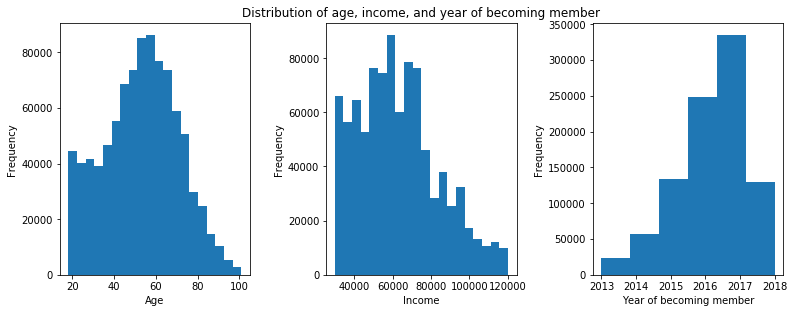

In [68]:
# Visualize the distribution of the age, income, and year of becoming member of the customers
fig, axis = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.0, right=1.8)

ax_1 = df['age'].plot.hist(ax=axis[0], bins=20)
ax_2 = df['income'].plot.hist(ax=axis[1], bins=20)
ax_3 = df['became_member_on'].plot.hist(ax=axis[2], bins=6)

ax_1.set_xlabel('Age')
ax_2.set_xlabel('Income')
ax_2.set_title('Distribution of age, income, and year of becoming member')
ax_3.set_xlabel('Year of becoming member')

Most of the customers were between 35 to 75 years old, the main income range of the customers was within 40k-75k dollars, and the majority of the customers in this experiment became members after 2015. 

Note that there were the most customers who became members in 2017 followed by 2016, possibly due to the expansion of the business into new markets or some other factors such as new marketing strategies which caused an increase in the number of members in these two years. 

### Demographic features, offer types, and channels vs. response

In [127]:
# Note that responded = 1 means responded and responded =0 means the customer didn't respond

# Response rate in different demographic groups
age_mean = df.groupby('responded').age.mean()
income_mean = df.groupby('responded').income.mean()
became_member_on_percent = df.groupby('became_member_on').responded.mean()
gender_percent = df.groupby('gender').responded.mean()

# Response rate to different offer types
offer_type = df.groupby('offer_type').responded.mean()

# Response rate to different channels
email_response = np.round(df[df['email'] == 1]['responded'].mean(),2)
web_response = np.round(df[df['web'] == 1]['responded'].mean(),2)
mobile_response = np.round(df[df['mobile'] == 1]['responded'].mean(),2)
social_response = np.round(df[df['social'] == 1]['responded'].mean(),2)

# Amount of money spent by different response groups
amount = df.groupby('responded').amount.mean()

print('Mean age in response vs. no-response groups: {}'.format(age_mean))
print('')
print('Mean income in response vs. no-response groups: {}'.format(income_mean))
print('')
print('Response rate for customers who became menbers in different years {}'.format(became_member_on_percent))
print('')
print('Response rate in different genders {}'.format(gender_percent))
print('')
print('Response rate to different offer types: {}'.format(offer_type))
print('')
print('Response rates to different channels are email: {}, web: {}, mobile: {}, and social: {}'.\
      format(email_response, web_response, mobile_response, social_response))
print('')
print('The amount of money spent by different responsive groups: {}'.format(amount))

Mean age in response vs. no-response groups: responded
0    51.408557
1    53.968619
Name: age, dtype: float64

Mean income in response vs. no-response groups: responded
0    58627.886494
1    65163.712595
Name: income, dtype: float64

Response rate for customers who became menbers in different years became_member_on
2013    0.546505
2014    0.529686
2015    0.680716
2016    0.725323
2017    0.660626
2018    0.492933
Name: responded, dtype: float64

Response rate in different genders gender
F    0.701842
M    0.604663
O    0.721570
Name: responded, dtype: float64

Response rate to different offer types: offer_type
bogo             0.722768
discount         0.785644
informational    0.000000
Name: responded, dtype: float64

Response rates to different channels are email: 0.65, web: 0.7, mobile: 0.66, and social: 0.73

The amount of money spent by different responsive groups: responded
0    11.158633
1    17.119849
Name: amount, dtype: float64


#### Summaries

The mean age seemed to differ only slightly between the responsive and unresponsive groups, with a mean age of about 51 in the unresponsive group and 54 in the responsive group. 

Other other hand, responsive customers seemed to have a higher mean income of 65k dollars than their unresponsive fellows whose mean income is about 59k dollars. 

Customers who became members during 2015-2017 appeared to have higher response rates than thos who obtained membership in other years. 

In addition, gender also seemed to matter, with a response rate of about 70% from female customers as opposed to about 60% from their male counterparts. Note that the 'O' gender might refer to those who don't want to provide their gender information or they don't consider themselves as either female or male in the conventional way. These customers seemed to have a even higher response rate (72%) than customers of other genders.

Customers also reponded to differnt offer types differently as well, with discount having about 79% response and bogo having 72%. Informational offers did not seem to relate to any responses, which is more or less unexpected but still kind of understandable. 

Different channels seemed to be correlated to differnt levels of response rates as well, with 70% and 73% response rates to the web and social media channels, respectively. Email and mobile channels, on the other hand, had similar response rates as 65% and 66%, respectively.

Finally, responsive customers spent 17 dollars on average compared to 11 dollars spent by unresponsive customers. 

Based on these results, I will visualize the relationships between our interested metrics including response, offer types, offer channels,and  amount of money spent by the cutomers and some demographic features particularly including income, age, joining year (year of becoming members), and gender.

### Visualizations: different features vs. response rate

Because the data structure in the df data makes it tricky to visualize the distribution of response rate to differnt channels, I will create a dataframe called channel which has a new column 'channel' containing different channel names.

In [106]:
# Create subsets for each channel
email = df[df['email'] == 1].copy()
web = df[df['web'] == 1].copy()
mobile = df[df['mobile'] == 1].copy()
social = df[df['social'] == 1].copy()

# Create a column called 'channel' containing the channel names
email['channel'] = 'email'
web['channel'] = 'web'
mobile['channel'] = 'mobile'
social['channel'] = 'social'

# Create a channel dataframe from the subsets
channel = pd.concat([email, web, mobile, social], axis=0)

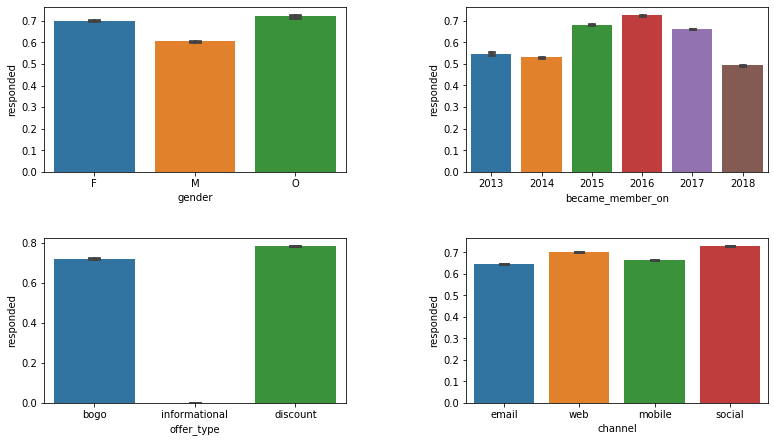

In [108]:
# Response rate in differnt gender, joining time, and offer type groups
fig, axis = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.5, right=1.8)

ax1 = sns.barplot(x=df['gender'], y=df['responded'], capsize=.1, ax=axis[0,0])
ax2 = sns.barplot(x=df['became_member_on'], y=df['responded'],  capsize=.1, ax=axis[0,1])
ax3 = sns.barplot(x=df['offer_type'], y=df['responded'], capsize=.1, ax=axis[1,0])
ax4 = sns.barplot(x=channel['channel'], y=channel['responded'], capsize=.1, ax=axis[1,1])

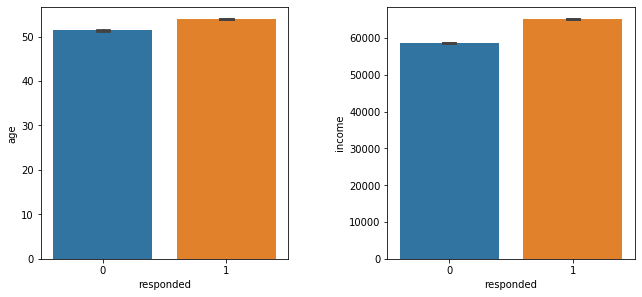

In [133]:
# The mean of income and age in different response groups
fig, axis = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.0, right=1.5)

sns.barplot(x=df['responded'], y=df['age'], capsize=.1, ax=axis[0])
sns.barplot(x=df['responded'], y=df['income'], capsize=.1, ax=axis[1])

### Demographic features vs. offer types

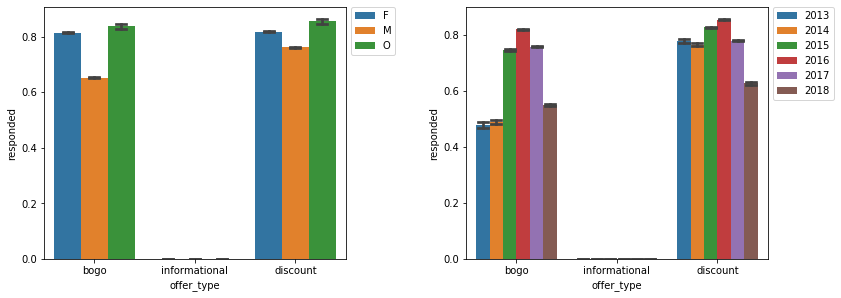

In [116]:
# Response rate in different gender and joining time groups grouped by offer types
fig, axis = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.0, right=1.8)

ax1 = sns.barplot(x=df['offer_type'], y=df['responded'], hue=df['gender'], capsize=.1, ax=axis[0])
ax2 = sns.barplot(x=df['offer_type'], y=df['responded'], hue=df['became_member_on'], capsize=.1, ax=axis[1])

ax1.legend(bbox_to_anchor=(1.0, 1.02))
ax2.legend(bbox_to_anchor=(1.0, 1.02))

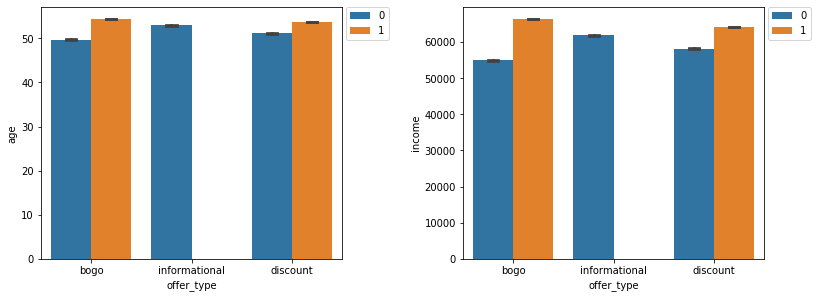

In [118]:
# The relationship between income, age, offer types, and response 
fig, axis = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.0, right=1.8)

ax1 = sns.barplot(x=df['offer_type'], y=df['age'], hue=df['responded'], capsize=.1, ax=axis[0])
ax2 = sns.barplot(x=df['offer_type'], y=df['income'], hue=df['responded'], capsize=.1, ax=axis[1])

ax1.legend(bbox_to_anchor=(1.17, 1.02))
ax2.legend(bbox_to_anchor=(1.17, 1.02))

### Demographic features vs. channels

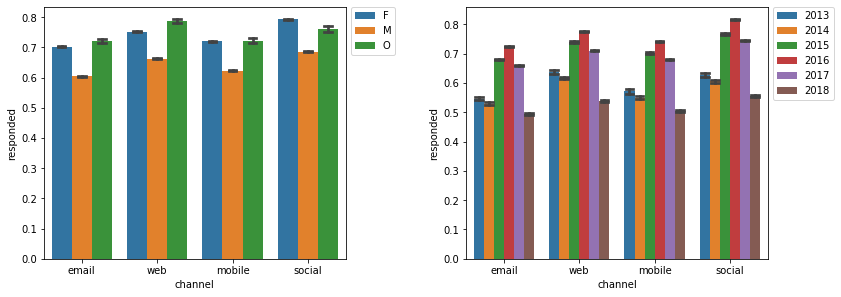

In [115]:
# Response rate in different gender and joining time groups grouped by channels
fig, axis = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.0, right=1.8)

ax1 = sns.barplot(x=channel['channel'], y=channel['responded'], hue=channel['gender'], capsize=.1, ax=axis[0])
ax2 = sns.barplot(x=channel['channel'], y=channel['responded'], hue=channel['became_member_on'], capsize=.1, ax=axis[1])

ax1.legend(bbox_to_anchor=(1.0, 1.02))
ax2.legend(bbox_to_anchor=(1.0, 1.02))

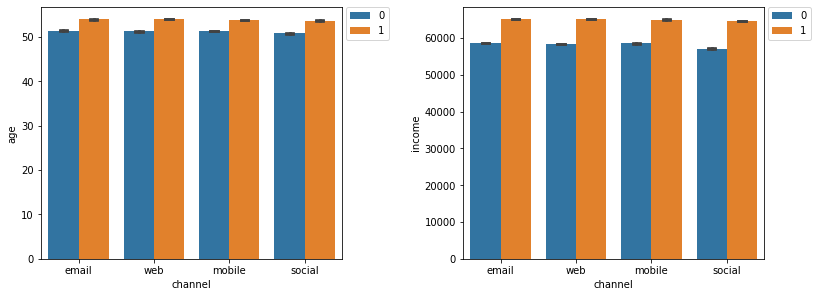

In [119]:
# The relationship between income, age, offer types, and response 
fig, axis = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.0, right=1.8)

ax1 = sns.barplot(x=channel['channel'], y=channel['age'], hue=channel['responded'], capsize=.1, ax=axis[0])
ax2 = sns.barplot(x=channel['channel'], y=channel['income'], hue=channel['responded'], capsize=.1, ax=axis[1])

ax1.legend(bbox_to_anchor=(1.17, 1.02))
ax2.legend(bbox_to_anchor=(1.17, 1.02))

### The amount of money spent

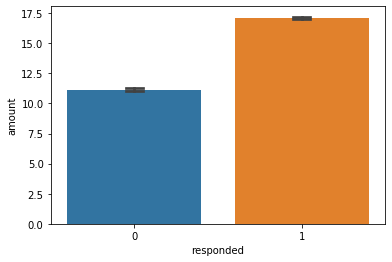

In [129]:
# The mean amount of money spent by different response groups
sns.barplot(x=df['responded'], y=df['amount'], capsize=.1)

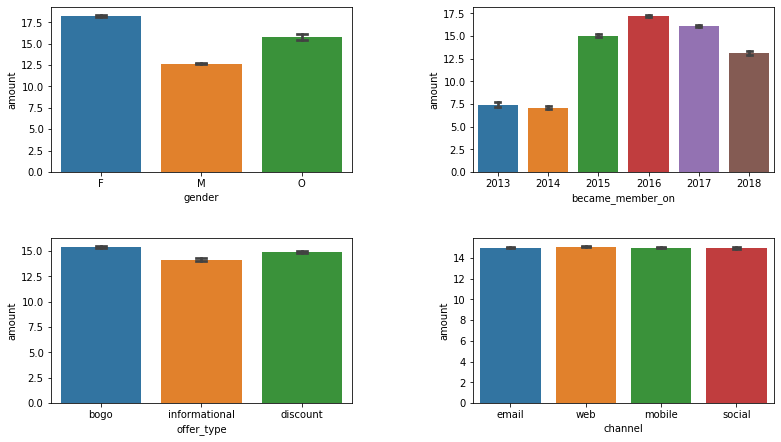

In [130]:
# The mean amount of money spent by differnt genders, joining time, offer types, and channels
fig, axis = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.5, right=1.8)

sns.barplot(x=df['gender'], y=df['amount'], capsize=.1, ax=axis[0,0])
sns.barplot(x=df['became_member_on'], y=df['amount'], capsize=.1, ax=axis[0,1])
sns.barplot(x=df['offer_type'], y=df['amount'], capsize=.1, ax=axis[1,0])
sns.barplot(x=channel['channel'], y=channel['amount'], capsize=.1, ax=axis[1,1])

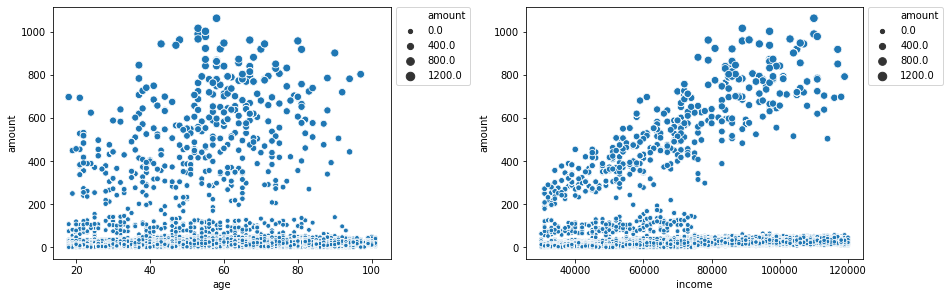

In [128]:
# The amount of money spent by customers of different income and ages
fig, axis = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=1.0, right=2.0)

ax1 = sns.scatterplot(x=df['age'], y=df['amount'], size=df['amount'], ax=axis[0])
ax2 = sns.scatterplot(x=df['income'], y=df['amount'], size=df['amount'], ax=axis[1])

ax1.legend(bbox_to_anchor=(1.0, 1.02))
ax2.legend(bbox_to_anchor=(1.0, 1.02))

Based on the previous analysis and visuliaztions, we could put the results together and draw some tentative conclusions in response to our business questions. Note that the demographic features in this project include age, gender, income, and joining year (became_member_on).

### Results

#### Who were more likely to respond?

Customers' gender, joining year (became_member_on), income, and age all seemed to affect the response rate, although it's notable that the difference in the mean age between the response and non-response groups was only three year old.

Overall, customers who were female, became members during 2015-2017, and had higher income were more likely to respond to the offers than others.

#### Which offer types had the most response?

Overall, discount offers seemed to have higher response rates compared to bogo offers. Informational offers didn't seem to relate to any responses, so I won't discuss this type further with differnt demographic features.  

- **Gender**

Female and 'O' customers had higher response rates than male customers to both bogo and discount offers, and this trend is stronger for bogo offers. 

The reason for this was that female as well as 'O' customers seemed to respond similarly to different offer types, whereas male customers seemed to respond more to discount offers than bogo offers.

- **Joining year**

Bogo offers appeared to have higher response rates from customers who became members during 2015-2017 than those who became member in other years. 

Discount offers, on the other hand, had relatively similar response rates from customers who became members during 2013-2017, with customers from 2018 having the a much lower response rate compared to those from other years.

- **Age and income**

For both bogo and discount offers, responsive customers seemed to have older ages and higher income than their unresponsive counterparts, and the income difference was bigger between responsive and unresponsive groups than the age differnce. 

In addition, the difference between response groups was bigger for bogo offers than for discount offers.

#### Which channels had the most response?

In general, social media and web appeared to have higher response rates (73% and 70%, respectively) than mobile and email channels (66% and 65%, respectively). 

- **Gender** 

Female and 'O' customers seemed to have higher response rates than male customers for all channels, and all three genders responded more to social media offers and web than to mobile and email. 

However, unlike the general trend in which social median had the highest response rate, 'O' customers seemed to have the highest response rate to web offers, indicating a close connection between customers from this gender group and web.

- **Joining year**

For all channels, customers who became members during 2015-2017 appeared to have higher response rates than those who became members in other years. Channels didn't seem to affect this trend among joining years.

- **Age and income**

Similar to offer types, all channels seemed to have older ages and higher income in the responsive group compared to the unresponsive group, and income difference was bigger between responsive and unresponsive groups than the age differnce.  


#### Who were more likely to spend more?

Overall, customers who responded to the offers seemed to spend more money on average (about 17 dollars) than those who didn't respond (about 11 dollars), suggesting that it is indeed important to take measures to improve the response rate.

- **Gender**

Female customers seemed to spend the most, followed by 'O' and male customers. 

- **Joining year**

Customers who became members during 2015-2018 seemed to spend more than thos who bemame members earlier than 2015.

- **Age and income**

Age didn't seem to have a strong correlation with the amount of money spent, although customers between 55 and 65 years old seemed to spend the most and those who were younger than 40 seemed to spend less than others. As for income, the trend seemed to be quite strong that oder peole spent more than younger customers.

- **Offer types**

Customers who received bogo offers seemed to spend more than those who received discount offers, with those who received informational offers spending the least, although the difference was rather small among different offer types.

- **Channels**

Different channels didn't seem to affect the amount of money spent, with customers from all channels having a mean of about 15 dollars. 

### Conclusions and Suggestions

In order to increase revenues, it makes sense for the company to promote the response rate, because people who responded indeed seemed to spend more than those who didn't respond. Particularly, the response rate could be improved through two aspects, including (1) identify customers with certain demographic features and (2) customize offers for different demographic groups by adjusting offer types and channels to deliver the offers.

**Demographic features**

The company might want to primarily focus on female customers and people with higher income. They are more responsive to offers and they also spend more than other. 

Age didn't seem to be a good indicator for either the response rate or amount of money spent according to the data, although the company might want to consider that peole around 55-65 spend more on average when constructing strategies. 

Finally, people who became members during 2015-2017 responed more and spent more than those who became member in other years, suggesting that the company might want to investigate into what made these three years different from other years. Were there new markets developed or were there any strategies applied during these years? Understanding the reason behind this year would be helpful for the company to improve its offer response rates. 

**Offer strategies**

In general, sending discount offers through social media seem to be the most promising way for the company to get a higer response rate. This is especially important for male customers, because they tend to respond more to the discounts while other genders don't have such a big different response rate to bogos and discounts.  

It's worthy mentioning that although discounts and social media had higher response rates in my analyis, people who received bogos actually spent slightly more than those who received discount and informational offers, and the amount of money spent by people from different channels was similar. This suggests that when trying to achieve a higher response rate, it is also important to factor in the cost of making these offers.  

# Data Modeling and Evaluation

In this part I will build a machine learning pipeline to predict the response of the customers. 

Logistic regressions will the proper way to make predictions in this situation, because I am predicting whether or not a customer will respond to offers. Specifically, I will build a machine learning pipeline to chain a PCA and a logistic regression. In order to improve the performance of the model, I will also use GridSearchCV in the process.

In [149]:
# Write a function to prepare X and y 
def prepare_data(df=df):
    '''
    INPUT - a dataframe df to draw our X and y from
    OUTPUT - X and y, two dataframes for the following modeling
    '''
    # Read in the cleaned data
    df = pd.read_csv('data/starbucks_cleaned.csv')
    
    # Create X and Y for the modeling
    subset = df.drop(['time_offer_received', 'customer_id', 'offer_id', 'time_offer_viewed',
           'time_offer_completed', 'time_transaction', 'amount'], axis=1)

    # Drop the rows with missing data, which are rows for customers who didn't receive an offer as discussed before
    subset = subset.dropna()

    X = subset.drop('responded', axis=1)
    y = subset['responded']
    
    # Create dummy variables for categorical features
    join_time_cat = pd.get_dummies(X['became_member_on'], drop_first=True)
    gender_cat = pd.get_dummies(X['gender'], drop_first=True)
    offer_type_cat = pd.get_dummies(X['offer_type'], drop_first=True)

    # Concat the dummy columns to X
    X_1 = pd.concat([X, join_time_cat], axis=1).drop('became_member_on', axis=1)
    X_2 = pd.concat([X_1, gender_cat], axis=1).drop('gender', axis=1)
    X = pd.concat([X_2, offer_type_cat], axis=1).drop('offer_type', axis=1)

    return X, y

In [150]:
# Call the prepare_data function to create X and y
X, y = prepare_data()

# Split the data to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [151]:
# Build a machine learning pipeline to chain a PCA and a SGDClassifier for the prediction
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipeline = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Fit the model 
pipeline.fit(X_train, y_train)

# Predict
y_pred_1 = pipeline.predict(X_test)

# Test the model
print(classification_report(y_pred_1, y_test))

              precision    recall  f1-score   support

           0       0.63      0.41      0.50    163577
           1       0.52      0.72      0.60    142648

    accuracy                           0.56    306225
   macro avg       0.57      0.57      0.55    306225
weighted avg       0.58      0.56      0.55    306225



A weighted average of precision of 0.58 is less than acceptable, so I will use GridSearchCV try to improve the predicting precision of the model.

In [152]:
# Try to improve the model by using GridSearchCV
param = {
    'pca__n_components': [2, 6, 10, 12, 18],
    'logistic__alpha': np.logspace(-4, 4, 5)
}

search = GridSearchCV(pipeline, param, iid=False, cv=5, n_jobs=4, verbose=2)

# Fit the new model 
search.fit(X_train, y_train)

# Predict
y_pred_2 = search.predict(X_test)

# Test the model
print(classification_report(y_pred_2, y_test))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  3.1min finished


              precision    recall  f1-score   support

           0       0.68      0.41      0.51    180649
           1       0.46      0.73      0.56    125576

    accuracy                           0.54    306225
   macro avg       0.57      0.57      0.54    306225
weighted avg       0.59      0.54      0.53    306225



Using grid search slightly increased the weighted average precision of the model from 0.58 to 0.59, which is not really a whole lot better. 

There are a few possible ways to improve the performance of the model, including trying other algorithms and add more features. I will try the LogisticRegression algorithm and see if ti can improve the performance or not.

In [154]:
# Build a pipeline to chain a PCA and a LogisticRegression for the prediction
logistic = LogisticRegression()
pca = PCA()
pipeline_2 = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Fit the model
pipeline_2.fit(X_train, y_train)

# Predict
y_pred_3 = pipeline_2.predict(X_test)

# Test the model
print(classification_report(y_pred_3, y_test))

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.60      0.81      0.69     80682
           1       0.92      0.81      0.86    225543

    accuracy                           0.81    306225
   macro avg       0.76      0.81      0.78    306225
weighted avg       0.84      0.81      0.82    306225



In [155]:
# Use GridSearchCV to improve the new pipeline
param = {'pca__n_components': [2, 6, 10, 12, 18], 
         'logistic__C': [0.1, 10.]}

search = GridSearchCV(pipeline_2, param, iid=False, cv=5, n_jobs=4, verbose=2)

# Fit  
search.fit(X_train, y_train)

# Predict
y_pred_4 = search.predict(X_test)

# Test the model
print(classification_report(y_pred_4, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.6min finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.55      0.85      0.67     69554
           1       0.95      0.79      0.86    236671

    accuracy                           0.81    306225
   macro avg       0.75      0.82      0.76    306225
weighted avg       0.86      0.81      0.82    306225



By using LogisticRegression instead of SGDClassifier, with the combination of GridSearchCV, the performance of the model was improved from 0.58 to 0.86, which is quite an improvement. This shows how important it is to select proper algorithms in modeling. 

By trying out other suitable algorithms, the performance of the model might be able to further improve. However, for now, I decide that I will move on to putting up the findings into a blog post on Medium.

# Deployment / Communications

The findings of the above analysis will be put together into a blog post on Medium.